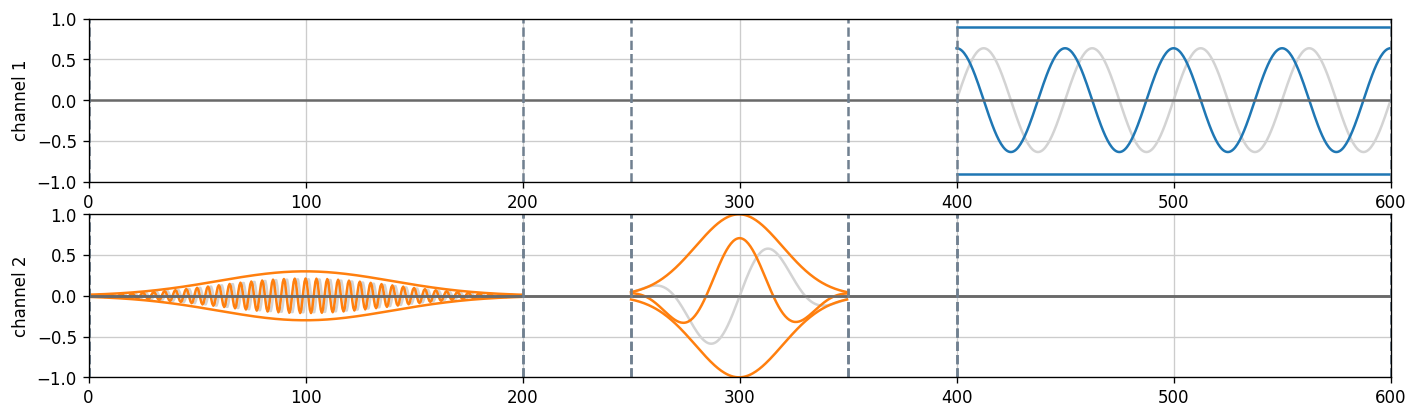

In [1]:
from qibolab.pulses import Pulse, PulseSequence, ReadoutPulse, PulseShape
from qibolab.instruments.zhinst import SHFQC_QA
import laboneq.simple as lo
import numpy as np

PulseShape.SAMPLING_RATE = 2e9

sequence = PulseSequence()


sequence.add(
    Pulse(
        start=0,
        amplitude=0.3,
        duration=200,
        frequency=200_000_000,
        relative_phase=0,
        shape="Gaussian(5)",  # Gaussian shape with std = duration / 5
        channel=2,
        qubit=0,
    )
)

sequence.add(
    Pulse(
        start=250,
        amplitude=1,
        duration=100,
        frequency=20_000_000,
        relative_phase=0,
        shape="Drag(5, 10)", 
        channel=2,
        qubit=0,
    )
)

sequence.add(
    ReadoutPulse(
        start=400,
        amplitude=0.9,
        duration=200,
        frequency=20_000_000,
        relative_phase=0,
        shape="Rectangular",
        channel=1,
        qubit=0,
    )
)

sequence.plot()

In [4]:
runcard = "qibolab/src/qibolab/runcards/zhinst.yml"
Device = SHFQC_QA('EL_ZURO', "DEV12146", runcard, use_emulation=True)
msr,phase, i , q = Device.execute_pulse_sequence(sequence)

2022.11.16 14:00:22.908 laboneq.controller.laboneq_logging INFO   Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is /home/admin/Juan/laboneq_output/log
2022.11.16 14:00:22.909 laboneq.controller.controller  INFO   VERSION: laboneq 1.2
2022.11.16 14:00:22.909 laboneq.controller.controller  INFO   Connecting to data server at localhost:8004
2022.11.16 14:00:22.910 laboneq.controller.communication INFO   Connected to Zurich Instrument's Data Server version 22.02 at localhost:8004
2022.11.16 14:00:22.910 laboneq.controller.communication INFO   Create AWG module dev12146:awg_module0
2022.11.16 14:00:22.911 laboneq.controller.communication INFO   Create AWG module dev12146:awg_module1
2022.11.16 14:00:22.911 laboneq.controller.communication INFO   Create AWG module dev12146:awg_module2
2022.11.16 14:00:22.912 laboneq.controller.communication INFO   Create AWG module dev12146:awg_module3
2022.11.16 14:00:22.913 laboneq.controller.communication IN

In [5]:
print(msr, phase, i, q)

59.39696961966999 0.7853981633974483 42.0 42.0


2022.11.16 13:57:10.410 laboneq.pulse_sheet_viewer.pulse_sheet_viewer INFO   Writing html file to /home/admin/Juan/Pulse_sheet_2022-11-16-13-57-10.html


/home/admin/Juan/Pulse_sheet_2022-11-16-13-57-10.html

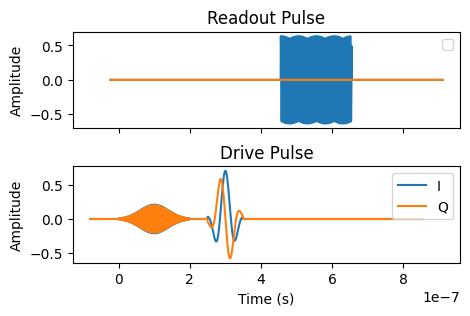

In [3]:
Device.plot_output_signals()
lo.show_pulse_sheet("Pulse_sheet",Device.exp)

------------------------------------------------------

Resonator Sprectoscopy similar to what we have (WIP)

In [8]:
from qibocal.calibrations.characterization.utils import variable_resolution_scanrange
from qibocal.data import DataUnits

def resonator_spectroscopy(
    Device,
    qubit: int,
    lowres_width,
    lowres_step,
    highres_width,
    highres_step,
    software_averages,
):

    Device.reload_settings()
    
    sequence = PulseSequence() 
    ro_pulse = Device.create_qubit_readout_pulse(qubit, start=0)
    sequence.add(ro_pulse)

    resonator_frequency = Device.characterization["single_qubit"][qubit][
        "resonator_freq"
    ]
    

    frequency_range = (
        variable_resolution_scanrange(
            lowres_width, lowres_step, highres_width, highres_step
        )
        + resonator_frequency
    )
    fast_sweep_data = DataUnits(
        name=f"fast_sweep_q{qubit}", quantities={"frequency": "Hz"}
    )
    
    for _ in range(software_averages):
        for freq in frequency_range:
                
            Device.reload_settings()
            
            Device.instruments['shfqc_qa']['settings']['lo_frequency'] = freq - ro_pulse.frequency
            
            Device.def_calibration()
            Device.Z_setup()
            
            print(Device.instruments['shfqc_qa']['settings']['lo_frequency'])
            
            msr, phase, i, q = Device.execute_pulse_sequence(sequence)
            
            results = {
                "MSR[V]": msr,
                "i[V]": i,
                "q[V]": q,
                "phase[rad]": phase,
                "frequency[Hz]": freq,
            }
            
            fast_sweep_data.add(results)

            # Plot simulated output signals
            Device.plot_output_signals()
            
    return fast_sweep_data

2022.11.16 14:06:11.071 laboneq.controller.laboneq_logging INFO   Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is /home/admin/Juan/laboneq_output/log
2022.11.16 14:06:11.072 laboneq.controller.controller  INFO   VERSION: laboneq 1.2
2022.11.16 14:06:11.072 laboneq.controller.controller  INFO   Connecting to data server at localhost:8004
2022.11.16 14:06:11.073 laboneq.controller.communication INFO   Connected to Zurich Instrument's Data Server version 22.02 at localhost:8004
2022.11.16 14:06:11.073 laboneq.controller.communication INFO   Create AWG module dev12146:awg_module0
2022.11.16 14:06:11.074 laboneq.controller.communication INFO   Create AWG module dev12146:awg_module1
2022.11.16 14:06:11.074 laboneq.controller.communication INFO   Create AWG module dev12146:awg_module2
2022.11.16 14:06:11.075 laboneq.controller.communication INFO   Create AWG module dev12146:awg_module3
2022.11.16 14:06:11.075 laboneq.controller.communication IN

/opt/anaconda3/envs/JQibo/lib/python3.9/site-packages/laboneq/simulator/wave_scroller.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  snippet[wave_start_samples : wave_start_samples + len(wave)] = wave
/opt/anaconda3/envs/JQibo/lib/python3.9/site-packages/laboneq/simulator/wave_scroller.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  snippet[wave_start_samples : wave_start_samples + len(wave)] = wave
/opt/anaconda3/envs/JQibo/lib/python3.9/site-packages/laboneq/simulator/wave_scroller.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  snippet[wave_start_samples : wave_start_samples + len(wave)] = wave
/opt/anaconda3/envs/JQibo/lib/python3.9/site-packages/laboneq/simulator/wave_scroller.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  snippet[wave_start_samples : wave_start_samples + len(wave)] = wave
/opt/anaconda3/envs/JQibo/lib/python3.9/site-pac

7780000000
2022.11.16 14:06:11.720 laboneq.compiler.compiler      INFO   Additional debug logging disabled for laboneq.compiler.compiler
2022.11.16 14:06:11.720 laboneq.compiler.compiler      INFO   Starting LabOne Q Compiler run...
2022.11.16 14:06:11.729 laboneq.compiler.compiler      INFO   Total seqC lines generated: 5
2022.11.16 14:06:11.729 laboneq.compiler.compiler      INFO   Total sample points generated: 3024
2022.11.16 14:06:11.730 laboneq.compiler.compiler      INFO   Finished LabOne Q Compiler run.
2022.11.16 14:06:11.814 laboneq.controller.controller  INFO   Starting near-time execution...
2022.11.16 14:06:11.816 laboneq.controller.controller  INFO   Finished near-time execution.
7780050000
2022.11.16 14:06:11.838 laboneq.compiler.compiler      INFO   Additional debug logging disabled for laboneq.compiler.compiler
2022.11.16 14:06:11.838 laboneq.compiler.compiler      INFO   Starting LabOne Q Compiler run...
2022.11.16 14:06:11.847 laboneq.compiler.compiler      INFO   To

/opt/anaconda3/envs/JQibo/lib/python3.9/site-packages/laboneq/simulator/wave_scroller.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  snippet[wave_start_samples : wave_start_samples + len(wave)] = wave
/opt/anaconda3/envs/JQibo/lib/python3.9/site-packages/laboneq/simulator/wave_scroller.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  snippet[wave_start_samples : wave_start_samples + len(wave)] = wave
/opt/anaconda3/envs/JQibo/lib/python3.9/site-packages/laboneq/simulator/wave_scroller.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  snippet[wave_start_samples : wave_start_samples + len(wave)] = wave
/opt/anaconda3/envs/JQibo/lib/python3.9/site-packages/laboneq/simulator/wave_scroller.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  snippet[wave_start_samples : wave_start_samples + len(wave)] = wave
/opt/anaconda3/envs/JQibo/lib/python3.9/site-pac

2022.11.16 14:06:12.013 laboneq.controller.controller  INFO   Starting near-time execution...
2022.11.16 14:06:12.014 laboneq.controller.controller  INFO   Finished near-time execution.


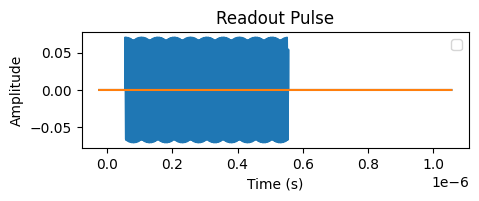

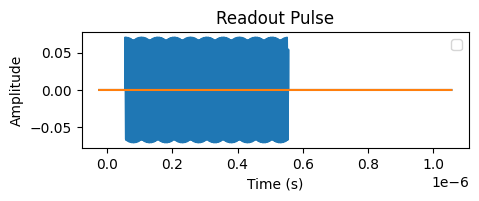

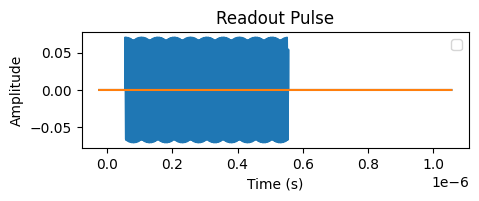

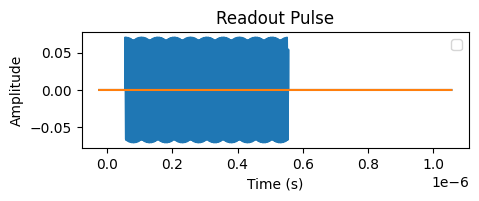

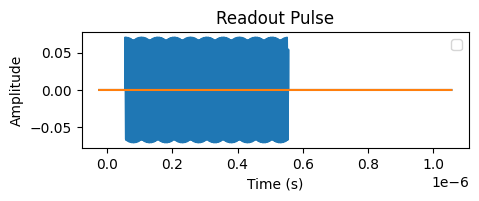

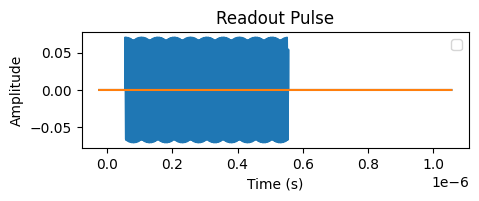

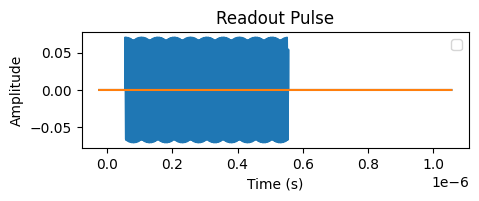

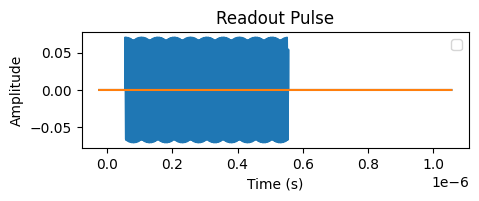

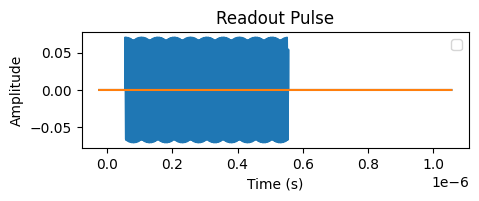

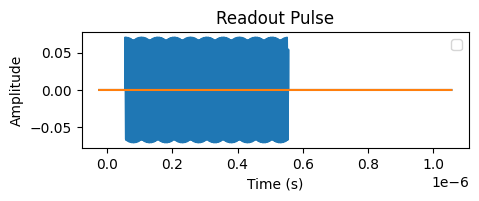

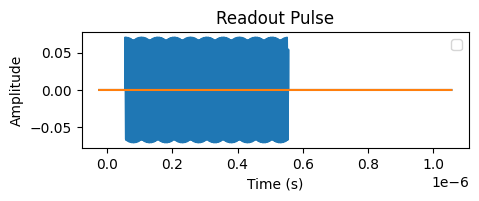

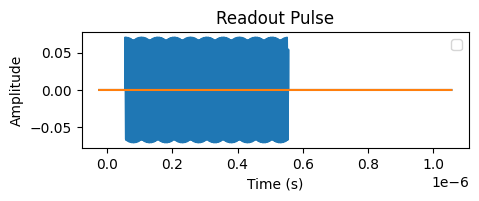

In [9]:
runcard = "qibolab/src/qibolab/runcards/zhinst.yml"

data = resonator_spectroscopy(
    Device = SHFQC_QA('EL_ZURO', "DEV12146", runcard, use_emulation=True),
    qubit = 0,
    lowres_width = 100_000_000,
    lowres_step = 25_000_000,
    highres_width = 100_000,
    highres_step = 50_000,
    software_averages=1,
    )


In [10]:
data.df

,frequency,MSR,i,q,phase
0,7700000000.0,59.39696961966999,42.0,42.0,45.0
1,7725000000.0,59.39696961966999,42.0,42.0,45.0
2,7750000000.0,59.39696961966999,42.0,42.0,45.0
3,7775000000.0,59.39696961966999,42.0,42.0,45.0
4,7799900000.0,59.39696961966999,42.0,42.0,45.0
5,7799950000.0,59.39696961966999,42.0,42.0,45.0
6,7800000000.0,59.39696961966999,42.0,42.0,45.0
7,7800050000.0,59.39696961966999,42.0,42.0,45.0
8,7800100000.0,59.39696961966999,42.0,42.0,45.0
9,7825100000.0,59.39696961966999,42.0,42.0,45.0
